In [1]:
using Pkg; Pkg.activate("../../NonLinearDynamicsCourse")

In [2]:
using Plots, DifferentialEquations, LinearAlgebra, Polynomials, Parameters
using BifurcationKit, Setfield, IntervalRootFinding, StaticArrays, JLD2
import BifurcationKit as BK

# Modelo de saxofon

El modelo esta formado por tres elementos principales:
- un oscilador (no lineal o en aproximacion lineal) de un grado de libertad correspondiente a la lengueta y excitado por la diferencia de presion entre el aire de la boquilla y de la boca del musico (ecuacion de Schumacher)
- Una ecuacion no lineal caracteristica (regularizada) que da el flujo de aire a traves del canal de la lengueta (derivada de la Ecuacion de Bernoulli). Ojo esta no es una ecuacion diferencial sino una ecuacion no lineal algebraica que me vincula el flujo con la diferencia de presion en la boquilla.
- Una descripcion modal de la impedancia del resonador que vincula el flujo con el flujo de aire y la presion (ecuacion de Webster).

Las variables principales del modelo son:

- $x$ : el desplazamiento de la lengueta desde el equilibrio
- $u$ : el flujo de aire entrando en la boquilla
- $p$ : la presion acustica dentro de la boquilla

<div>
<img src="model.png" width="700px">
</div>

En realidad estas variables estan expresadas como magnitudes adimensionales, definidas en funcion de las magnitudes y parametros fisicos del sistema real como:

$x = \large\frac{\hat{x}}{H}$ ;    $u = Z_C\large\frac{\hat{u}}{p_M}$ ;    $p = \large\frac{\hat{p}}{p_M}$ 

donde $H$ es la distancia entre el punto de equilibrio y el tope maximo de oscilacion, $p_M$ es la presion estatica necesaria para llevar la lengueta contra la boquilla y $Z_C$ es la impedancia caracteristica a la entrada del resonador. De esta forma el canal de la lengueta esta cerrado cuando $x<-1$.

Como $u$ no es una variable dinamica independiente, las variables dinamicas de nuestro sistema van a ser:

- $x$ : el desplazamiento de la lengueta desde el equilibrio
- $v$ : la velocidad de la lengueta (necesaria para la descripcion de un oscilador)
- $p_n$ : la presion (compleja) de cada uno de los modos (la presion total sera la suma de las partes reales de las presiones de cada modo)

Es decir para un sistema hiper-simplificado de un modo del tubo tenemos al menos tres ecuaciones diferenciales (una compleja) y luego para $N$ modos del tubo tendremos $N+2$ ecuaciones diferenciales

Los parametros de control son $\gamma$ que se corresponde con la presion de soplado, y $\zeta$ que se corresponde con la fuerza aplicada por el labio para controlar la apertura del canal en el reposo (en realidad expresa la posicion adimensionalizada por H de la lengueta en el reposo) y estan expresados tambien adimensionalmente.

$\gamma = \Large\frac{\hat{\gamma}}{p_M}$ ;     $\zeta = wHZ_c\sqrt{\Large\frac{2}{\rho p_M}}$

donde $w$ es el ancho efectivo de la lengueta, $\hat{\gamma}$ el valor fisico de la presion de soplado y $\rho$ la densidad del aire.

Referencias:
<div class="csl-entry">Colinot, T., Vergez, C., Guillemain, P., &#38; Doc, J. (2021). Multistability of saxophone oscillation regimes and its in fl uence on sound production. <i>Acta Acustica</i>, <i>5</i>(33).</div>
<div class="csl-entry">Colinot, T. (2020). <i>Numerical simulation of woodwind dynamics : investigating nonlinear sound production behavior in saxophone-like instruments Tesis doctoral</i>.</div>
<div class="csl-entry">Bilbao, S. D. (2009). <i>Numerical sound synthesis : finite difference schemes and simulation in musical acoustics (Seccion 9.3)</i>.</div> 

## Modelo de lengüeta

La lengüeta esta modelada como un oscilador con un solo grado de libertad forzado por la diferencia de presion entre la boquilla y la boca del musico y una no linealidad asociada a la fuerza de contacto entre la lengueta y la boquilla:

El oscilador armonico sin forzar y sin fuerza de contacto seria:

$\dot{x} = v$

$\dot{v} = -q_r\omega_r v - \omega_r^2 x $

Si agregamos el forzado $p - \gamma$ y la fuerza de contacto $F_c$:

$\dot{x} = v$

$\dot{v} = -q_r\omega_r v + \omega_r^2 (p-\gamma - x + F_c(x,v))$

donde $q_r$ es el coeficiente de amortiguacion, $\omega_r$ la frecuencia angular del modo de oscilacion de la lengüeta. Para reducir la cantidad de parametros libres podemos asumir: $\omega_r = 4.224$ rad/ms (0.6723 kHz), y $q_r = 1$ 

$F_c(x,v)$ es la fuerza de contacto y se puede modelar como 

$F_c(x,v) = K_c min(x+1,0)^2 (1 − \beta v)$    


donde $K_c=100$ es la rigidez no lineal de la boquilla y $\beta = 1 ms$ el coeficiente de amortiguacion no lineal. Para poca amplitud de oscilacion (valores de $\gamma$ bajos) puede despreciarse esta fuerza (aproximacion "ghost reed")

La funcion $min(x+1,0)$ se puede regularizar como:

$min(x+1,0) \approx \frac{1}{2} x+1-\sqrt{(x+1)^2+\eta}$

Con $\eta$ una constante de regularizacion pequeña

> _Esto debería ser:_ $ min(x+1,0) \approx \frac{1}{2} (x+1-\sqrt{(x+1)^2+\eta}) $

In [3]:
# funcion de contacto
function contact(x,v,β,Kc)
    Kc*min(real(x)+1.0,0)^2*(1-β*v)
end    

contact (generic function with 1 method)

In [4]:
# Lengueta sola
function reed_only!(dx,x,p,t)
    @unpack γ,β,ω0,Kc,P = p
    Fc = Kc*min(real(x[1])+1,0)^2*(1-β*x[2])
    dx[1] = x[2]
    dx[2] = -ω0*x[2]+ω0^2*(P-γ-x[1]+Fc)
end    

reed_only! (generic function with 1 method)

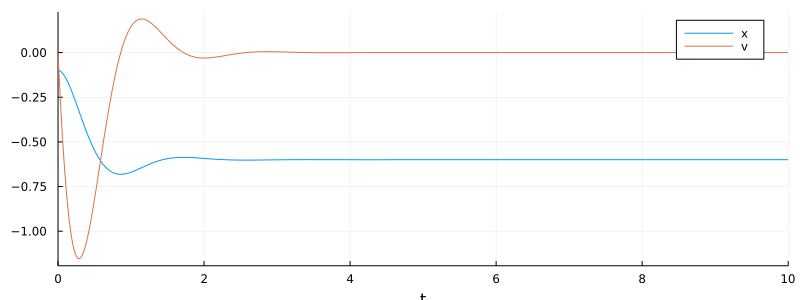

In [5]:
# definimos parametros como una named tupla pars
ω0=4.224 # nos va a servir mas adelante tenerlo definido por separado
pars1 = (γ=0.6,β=1,ω0=ω0,Kc=100,P=0.0)
# determinamos el time span y la condicion inicial x0
tspan = (0.0,10)
xini = [-0.1, 0]
# Definimos el problema pasando la funcion, condicion inicial time span y parametros y la resolvemos con solve
prob = ODEProblem(reed_only!, xini, tspan, pars1)
sol = solve(prob);
# grafico muy simple de las variables 
plot(sol,vars=1,label="x")
plot!(sol,vars=2,label="v",size=(800,300))

## Modelo del flujo de canal

El flujo total entrando a la boquilla se puede expresar como la suma del flujo debido al movimiento de la lengueta $u_r$ y el flujo a traves del canal $u_b$. Pero la contribucion del primero se puede despreciar.

La aproximacion que se usa es la que da Wilson & Beavers, que se deriva de la Ley de Bernoulli (aproximacion estatica en la que las oscilaciones son pequeñas - numero de Strouhal pequeño). Esta es la figura original del paper )en clarinete) para tener una idea de que es cada cosa:

<div>
<img src="wilson.png" width="300px">
</div>

En este grafico $P$ es la presion de soplado, lo que llamamos $\gamma$ y el area a se puede aproximar como $w \max(\hat{x}+H,0)$ donde $w$ es el ancho del canal y $\max(x+H,0)$ su altura. Una aproximacion importante es que el flujo en la cavidad externa se considera estacionario, es decir la energia es toda potencial: la del soplado. 

La ley de Bernoulli es otra forma de expresar la conservacion de la energia, en este caso tenemos energia potencial dada por la presion estatica y energia cinetica dada por la velocidad del flujo al cuadrado. La planteamos afuera y adentro. Afuera tenemos solo potencial $\gamma$ y adentro tenemos potencial $p$ (la presion en la boquilla) y la velocidad del flujo $U$. Igualando adentro y afuera tenemos

$\frac{1}{2}\rho U^2 + \hat{p} = \hat{\gamma}$

recordar que los sombreros los usamos para las magnitudes fisicas. 

Despejamos $U$ teniendo en cuenta que al sacar la raiz cuadrada tenemos dos soluciones una con signo positivo y otra con signo negativo (de ahi viene la funcion signo)

$U = sign(\hat{\gamma} - \hat{p}) \sqrt{\left| \large\frac{2(\hat{\gamma} - \hat{p})}{\rho}\right|}$

donde $U$ es la velocidad del flujo en la boquilla.

Lo que nos interesa para poder vincular esto con lo que pasa en el tubo es obtener el flujo volumetrico (o caudal) que es lo que se mantiene constante (por continuidad o conservacion de masa). El flujo volumetrico (fisico) $\hat{u}$ es simplemente la velocidad del flujo $U$ multiplicada por el area (seccion del canal) que habiamos dicho
que era $w\max(\hat{x}+H,0)$. Entonces tenemos:

$\hat{u} = w \max(\hat{x}+H,0) sign(\hat{\gamma} - \hat{p}) \sqrt{\left| \large\frac{2(\hat{\gamma} - \hat{p})}{\rho}\right|}$

Vamos a hacer un cambio a las variables adimensionalizadas. Al principio puede marear un poco porque visto todo de seguido la misma ecuacion parece complicarse. Pero como en una trama Hollywoodense al final todo se resuelve y quedamos en una situacion mejor que al principio.

Conviene pensarlo como un juego de reemplazos. Usando las definiciones de las variables adimensionalizadas que escribimos antes vamos reemplazando las variables con sombrero por las variables sin sombrero (adimensionalizadas) y al final todo el lio lo termina absorbiendo la variable adimensionalizada $\zeta$

Haciemos el cambio a variables adimensionalizadas la ecuacion queda:

$u\large\frac{p_M}{Z_c} = \small w H \sqrt{\large\frac{2}{\rho}}\max(x+1,0) sign(\gamma - p) \sqrt{\left|\gamma - p)\right|}$

despejamos $u$ y reordenamos algunos factores

$u = w H Z_c\sqrt{\large\frac{2}{\rho p_M}}\max(x+1,0) sign(\gamma - p) \sqrt{\left|\gamma - p)\right|}$

si reconocemos que lo que esta al principio es la definicion de $\zeta$ nos queda finalmente:

$u = \zeta \max(x+1,0)sign(\gamma-p)\sqrt{|\gamma-p|}$

### Regularizacion

Esta funcion de derivada discontinua se puede regularizar tambien haciendo

$\max(x+1,0) \approx \frac{1}{2} x + 1 + \sqrt{(x+1)^2+\eta}$

$|\gamma - p|  \approx \sqrt{(\gamma-p)^2+\eta}$

> _Esto debería ser:_ $\max(x+1,0) \approx \frac{1}{2} (x + 1 + \sqrt{(x+1)^2+\eta})$

In [6]:
# funcion de canal (sin regularizar)
function channel(x,p)
    @unpack γ,ζ,P = p
    u = ζ*max(real(x)+1,0)*sign(γ-P)*sqrt(abs(γ-P))
end    

channel (generic function with 1 method)

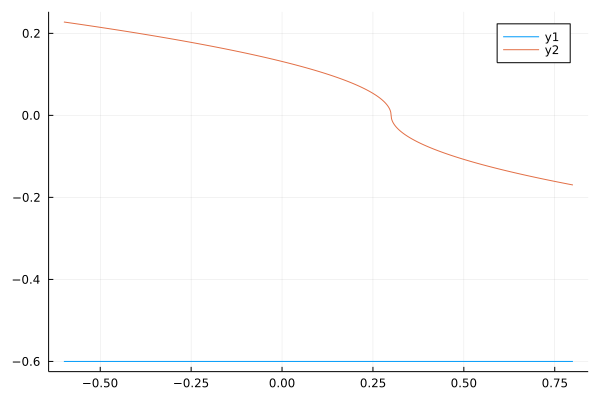

In [7]:
# vamos a variar la presion P y ver cual es la situacion final de equilibrio en x y en u, 
# para eso creamos una lista de valores de P P_list y dos arrays xfin ufin para almacenar los valores finales
P_list = -0.6:0.001:0.8
xfin =  Array{Float64}(undef, length(P_list))
ufin =  Array{Float64}(undef, length(P_list))
# hacemos un loop sobre los valores de P, resolvemos y almacenamos el ultimo valor de x y calculamos u
for (n,P) in enumerate(P_list)
    prob = ODEProblem(reed_only!, xini, tspan, pars1)
    sol = solve(prob, Tsit5())
    xfin[n] = sol[end][1]
    pars2 = (γ=0.3,ζ=0.6,P=P)
    ufin[n] = channel(xfin[n],pars2)
end    
plot(P_list,xfin)
plot!(P_list,ufin)

Como es de esperar cuando no hay presion en el tubo la posicion de la lengüeta (normalizada) $x$ es igual a la presion de soplado (normalizada) $\gamma$ cambiada de signo, y luego la posicion de la lengüeta crece linealmente con la presion dentro del tubo (salvo cuando llega a $x=-1$ porque colisiona con la boquilla).

El comportamiento del flujo es mas interesante porque como es de esperar es maximo cuando no hay oscilacion $p=0$, ya que es flujo estatico, pero es asimetrico segun si la presion del tubo mueve el aire dentro del tubo va a favor o en contra del flujo de soplado y para valores altos de presion se hace bruscamente negativo, es decir que el flujo "vuelve" debido a la oscilacion. Esto va a ser mas importante adelante para tener en cuenta en la interaccion con el tracto vocal del musico.

## Ecuaciones del resonador

La presion en la boquilla y la velocidad del flujo de ntrada estan vinculadas a traves de la impedancia de entrada, que es una funcion de la frecuencia, asi que descompuesto en modos el problema continuo en frecuencia se puede reducir a una ecuacion por cada uno de los $N$ modos activos de oscilacion. En esto si no vamos a entrar en detalle simplemente decir que es una forma de escribir la impedancia compleja $Z(\omega)$ a partir de los residuos y los polos:

$Z(\omega) = \Large\frac{P(\omega)}{U(\omega)} = \sum\limits_{n=0}^{N} \Large\frac{C_n}{i\omega-s_n} + \Large\frac{\bar{C}_n}{i\omega-\bar{s_n}}$

donde $C_n$ y $s_n$ son los residuos y polos complejos de los modos. Los polos se corresponden con los picos de la impedancia, son complejos y se pueden expresar como $s_n = -\alpha_n+j \omega_n$, donde la parte imaginaria $\omega_n$ corresponde a la frecuencia del pico de resonancia y $\alpha>0$ con su ancho. Los residuos se corresponden con la altura de los picos de resonancia. 

La respuesta temporal a un polo complejo es:

$h_n(t) = C_n e^{-\alpha t} e^{j \omega_n t}$

asi por ejemplo de la lista que da Colinot en el ultimo paper de 2021:

<div>
<img src="Modes1.PNG" width="500px">
</div>

podemos ver que el primer polo (pico de resonancia) esta en $\omega_n = 1195$ radianes / segundo, que corresponde a una frecuencia de $f_n = \omega_n/2\pi = 190 Hz$ (un F#, nota escrita D# en el alto)


# Parametros 

In [13]:
# PARAMETROS FIJOS EN LO QUE SIGUE PARA EL MODELO DE N MODOS
ωn = [1.195,2.483,3.727,4.405,5.153,6.177,6.749,7.987]
αn = [0.0176,0.0355,0.0653,0.2693,0.0703,0.166,0.0945,0.1165]
Cn = [0.1761,0.4705,0.6494,0.328,0.541,0.2249,0.3822,0.4099]
sn = -αn+1im*ωn
fs = 16.0
dt = 1/fs
pc = (γ=0.4,ζ=0.6,β=1.0,ω0=ω0,Kc=100.0,s=sn,C=Cn) # Complejos
pr = (γ=0.4,ζ=0.6,β=1.0,ω0=ω0,Kc=100.0,α=αn,ω=ωn,C=Cn) # Reales
γ = @lens _.γ; # para cambiar el valor (pars es inumtable)

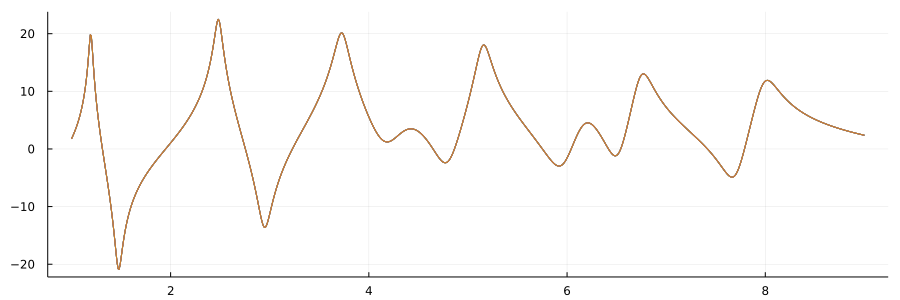

In [14]:
# calculamos la impedancia, notar que aca estamos usando la macro @. que aplica la todas las operaciones 
# sobre arrays elemento a elemento (elementwise) y estamos usando broacasting de un array de (801,8) ω, con
# arrays de (8,) traspuestos (sn y Cn)
ω = repeat(1:0.01:9.0,1,8)
Zs = @. Cn'/(1im*ω-sn')+conj(Cn')/(1im*ω-conj(sn'))
plot(ω,20*log10.(abs.(sum(Zs,dims=2))),size=(900,300),legend=false)

Se puede comparar este grafico con la tabla y ver como cada uno de los ocho picos del grafico se corresponde con cada uno de los ocho modos. Por un lado las posiciones de los maximos se corresponden con las frecuencias en radianes/s expresadas en kHz en el eje horizontal. Por otro lado, cuanto mayor en valor absoluto $\alpha$ (la parte real negativa del polo $s_n$), mas redondeado y bajo va a ser el pico (podemos pensarlo como la absorcion o la disipacion de la resonancia de ese modo). Asi por ejemplo el cuarto modo a $4.4 kHz$ es muy poco prominente debido al valor de $\alpha=-269$. Finalmente el residuo $C$ da la amplitud (si bien $\alpha$ tambien afecta la amplitud del pico haciendolo mas fino y alto o mas bajo y redondeado). Asi por ejemplo, si bien el segundo y tercer modo modo tienen mas disipacion que el primero (un valor absoluto de $\alpha$ mayor) responden con la misma amplitud por tener un residuo mayor. 

La expresion de la impedancia (en el dominio de frecuencia) nos va a permitir derivar una ecuación diferencial para los modos (en el dominio del tiempo).

Haciendo la transformada inversa de Fourier de $Z(\omega)$ obtenemos un sistema de N ecuaciones diferenciales ordinarias (pero complejas!). 

Comenzamos descomponiendo $Z(\omega)$ en los n modos y escribiendo cada modo como el cociente entre la presion del modo n y el flujo

$\Large\frac{P_n(\omega)}{U(\omega)} = \frac{C_n}{j\omega-s_n}$

$j\omega P_n(\omega) = s_nP_n(\omega)+C_n u$

Ahora, teniendo en cuenta de que la transformada de Fourier de una funcion armonica tiene como efecto agregar un termino $j\omega$, cuando realizamos la transformada inversa el efecto del factor $j \omega$ es el de introducir la derivada temporal, obteniendo ahora con $p_n(t)$ y $u(t)$ en el dominio del tiempo:

$\dot{p_n}=s_n p_n + C_n u$

con 

$p = 2\sum\limits_{n=1}^{N}Re(p_n)$

Con esto tenemos completo nuestro sistema, que va a constar de 2 ecuaciones diferenciales para el oscilador de la lengüeta, acoplado mediante Bernoulli con una ecuacion diferencial para cada modo complejo. 

Si bien trabajar en complejos hizo mas facil derivar las ecuaciones y los metodos numericos de integracion de las ecuaciones diferenciales pueden trabajar perfectamente con complejos, para hacer un analisis del sistema vamos a pasar mas adelante a un sistema en los numeros reales, con el costo de que vamos a tener el doble de ecuaciones para los modos. 

Pero para ganar un poco de comprension del problema vamos a analizar y simular primero el sistema mas simple posible con un solo modo.

# Caso 1 modo. 
Tenemos dos ecuaciones para la lengueta  y una para un modo, lo escribimos de forma explicita

$\dot{x} = v$

$\dot{v} = -\omega_r v + \omega_r^2 (p-\gamma-x+F_c)$

$\dot{p_1} = s_1 p_1 + C_1 u$

con las funciones sin regularizar:

$p=2 Re(p_1)$

$F_c = K_c min(x+1,0)^2 (1 − \beta v)$    

$u = \zeta max(x+1,0)sign(\gamma-p)\sqrt{|\gamma-p|}$

In [15]:
function sax!(dx,x,p,t)
    @unpack γ,ζ,β,ω0,Kc,s,C = p
    P = 2.0*real(x[3])
    Fc = Kc*min(real(x[1])+1,0)^2*(1-β*x[2])
    u = ζ*max(real(x[1])+1,0)*sign(γ-P)*sqrt(abs(γ-P))
    dx[1] = x[2]
    dx[2] = -ω0*x[2]+ω0^2*(P-γ-x[1]+Fc)
    dx[3] = s[1]*x[3]+C[1]*u
    dx
end

sax! (generic function with 1 method)

## Solucion Estacionaria con $\gamma=0.2$

Por ahora nuestro unico parametro de control es la presion de soplado $\gamma$. Vamos a empezar solpando "poquito", en este caso es $0.2$ es decir un $20\%$ de la presion necesaria para que la lengüeta toque la boquilla (recordar la adimensionalizacion). Tenemos que dar ademas de los parametros una condicion inicial. Una asuncion razonable seria que la lengüeta de desplaza ese mismo valor $0.2$ para los negativos. Tambien podriamos partir de la lengüeta en cero, pero como no nos va a interesar ese transitorio (si el que viene despues) en general vamos a poner como condicion inicial para la variable $x$ el valor de $-\gamma$. Obviamente asumimos velocidad cero y presion compleja cero dentro del tubo como condiciones iniciales.

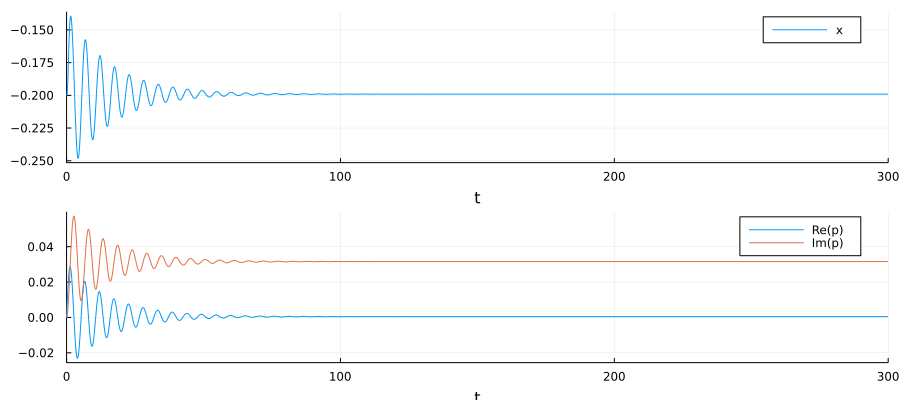

In [16]:
xini = [-0.2, 0, 0.0+0.0im] 
tspan = (0.0,300)
sol = solve(ODEProblem(sax!, xini, tspan, set(pc,γ,0.2)));
plt1 = plot(sol,vars=((t,x) -> (t,real(x)),0,1),label="x")
plt2 = plot(sol,vars=((t,x) -> (t,real(x)),0,3),label="Re(p)")
plot!(plt2,sol,vars=((t,x) -> (t,imag(x)),0,3),label="Im(p)")
plot(plt1,plt2,layout=(2,1),size=(900,400))

Como puede verse el desplazamiento inicial de la lengüeta genera una oscilacion amortiguada que en menos de 100 ms decae a un comportamiento estacionario con $x \approx -\gamma$. Algo similar sucede con la presion, con la salvedad de que la parte imaginaria tiene un estacionario notoriamiente distinto de cero. En realidad ninguna de las dos es cero. Si comparamos el valor final de la velocidad que esta en cero dentro del error numerico (eso va a depender del metodo de integracion), el valor final de la presion es aproximadamente $p_1 = 0.000465 + 0.0316 i$ lo cual es claramente diferente de cero en la parte real e imaginaria. Esto tiene sentido porque estamos soplando, y eso genera un aumento de presion leve positiva y estacionaria dentro del tubo.

In [17]:
sol.u[end]

3-element Vector{ComplexF64}:
   -0.19906948881333808 + 0.0im
 -2.0603450699692146e-8 + 0.0im
 0.00046525451216440563 + 0.03158971423299793im

## Solucion Oscilatoria con $\gamma=0.48$



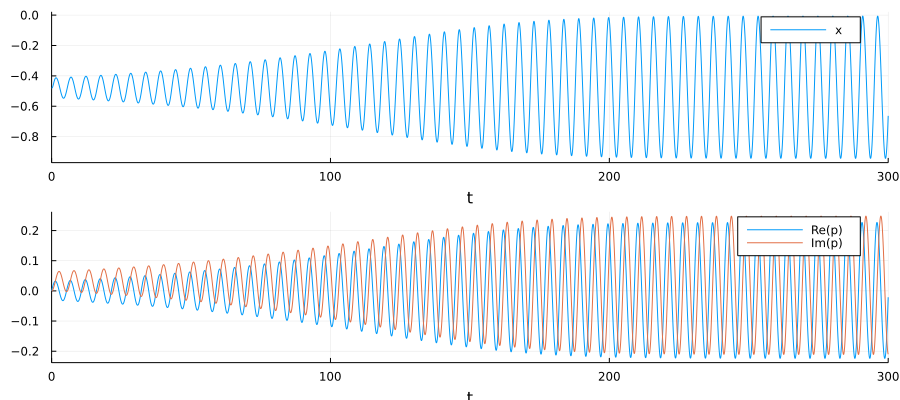

In [55]:
blow = 0.48
xini = [-blow, 0, 0.0+0.0im] 
tspan = (0.0,300)
sol1 = solve(ODEProblem(sax!, xini, tspan, set(pc,γ,blow)));
plt1 = plot(sol1,vars=((t,x) -> (t,real(x)),0,1),label="x")
plt2 = plot(sol1,vars=((t,x) -> (t,real(x)),0,3),label="Re(p)")
plot!(plt2,sol1,vars=((t,x) -> (t,imag(x)),0,3),label="Im(p)")
plot(plt1,plt2,layout=(2,1),size=(900,400))

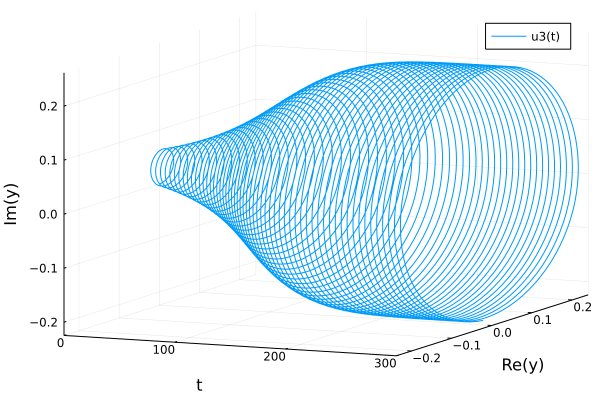

In [56]:
plot(sol1,vars=(0,3))

El ultimo grafico muestra que la presion compleja es simplemente una oscilacion que crecedesde un valor inicial (que no es cero porque no arrancamos del punto fijo luego veremos por que) hasta un valor maximo. Este es un ciclo limite atractor como puede verificarse cambiando la condicion inicial siempre converge a una oscilacion de la misma amplitud. Del grafico temporal puede verse a simple vista que hay aproximadamente 19 ciclos en 100 milisegundos, lo cual es consistente con una frecuencia de 190 Hz que es la que corresponde al primer modo.

Si para $\gamma=0.2$ convergiamos a un foco atractor (como se evidencia por las oscilaciones amortiguadas) y para $\gamma=0.48$ convergemos a un ciclo limite estable es de sospechar que para algun valor intermedio del parámetro se produzca una bifurcación de Hopf. Vamos a pasar a una versión en el dominio de los reales de las ecuaciones para poder analizarlas mejor.

# Version Real

Si bien derivamos la forma compleja que es mas compacta y es la que esta en el trabajo original de Collinot, la derivada de una funcion compleja (el modo $p_n$) con respecto al tiempo se puede separar en su parte real e imaginaria y lo mismo con el miembro derecho de la ecuacion. La contra es que ahora tendremos dos ecuaciones para cada modo, pero la ventaja es que la mayor parte de las herramientas de calculo numerico (por ejemplo el metodo de Newton y otras que estan en BifurcationKit) estan diseñadas para trabajar con numeros reales. Vamos a escribir nuestra variable de presion compleja como:

$p_n -> p_n/2 + i q_n$

Notar que estamos reutilizando $p_n$ para no vambiar la notacion por lo que de arriba no es una igualdad, ahora $p_n$ es la mitad de la parte real de la presion compleja que podemos renombrar como $\hat{p_n}$. Entonces
de forma mas correcta, si a partir de ahora marcamos con el $\hat{}$ las variables complejas:

$\hat{p_n} = p_n/2 + i q_n$

y la presion total como 

$p = \sum\limits_{n=1}^{N}p_n$

Notar que ahora no esta el factor 2 ni la parte real. Para el caso de un modo simplemente $p=p_1$.
La tercera ecuacion, para el caso de un modo quedaria, reemplazando la derivada y la nueva definicion de la presion como 

$\dot{p_1}/2+ i \dot{q_1} = (-\alpha_n+i\omega_n) (p_1/2+i q_1) + C_1 u(p_1)$

Separando en parte real e imaginaria tenemos ahora dos ecuaciones:

$\dot{p_1}= -\alpha_1 p_1 - 2\omega_1 q_1 + 2C_1 u(p_1)$

$\dot{q_1} = -\alpha_1 q_1 + \omega_n p_1/2$

las dos primeras ecuaciones del sistema no cambian salvo que ahora $p=p_1$ es directamente la tercer variable del sistema de ecuaciones. Escribimos el nuevo sistema de cuatro ecuaciones y comparamos con el resultado anterior para chequear.

In [57]:
function saxR!(dx,x,p,t)
    @unpack γ,ζ,β,ω0,Kc,α,ω,C = p
    Fc = Kc*min(x[1]+1,0)^2*(1-β*x[2])
    u = ζ*max(x[1]+1,0)*sign(γ-x[3])*sqrt(abs(γ-x[3]))
    dx[1] = x[2]
    dx[2] = -ω0*x[2]+ω0^2*(x[3]-γ-x[1]+Fc)
    dx[3] = -α[1]*x[3]-2*ω[1]*x[4]+2*C[1]*u
    dx[4] = -α[1]*x[4]+0.5*ω[1]*x[3]
    dx
end     

saxR! (generic function with 1 method)

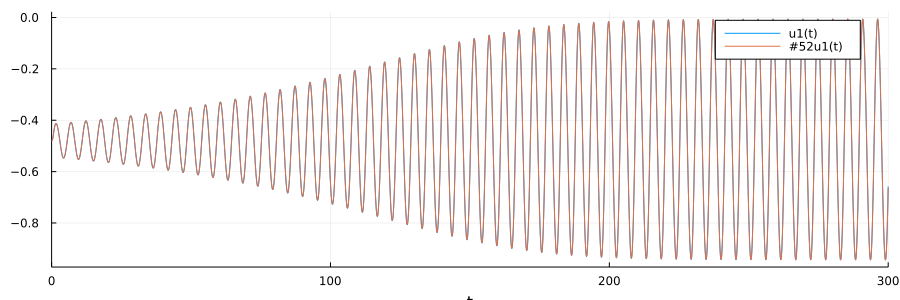

In [58]:
xini = [-blow, 0.0, 0.0, 0.0] 
sol2 = solve(ODEProblem(saxR!, xini, tspan, set(pr,γ,blow)));
plot(sol2,vars=(0,1),size=(900,300))
plot!(sol1,vars=((t,x) -> (t,real(x)),0,1))

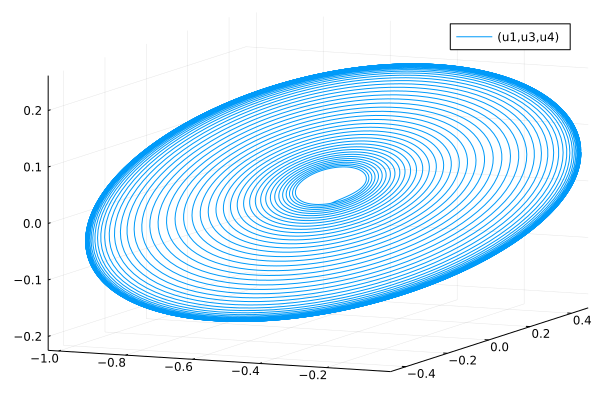

In [59]:
plot(sol2,vars=(1,3,4))

## Puntos Fijos y Bifurcaciones

Para el caso de un solo modo nos podemos aventurar a calcular los puntos fijos y su estabilidad. Vamos a usar la version real que a pesar de tener una dimension mas va a a facilitar los calculos. 

Vamos a tratar de dererminar el (o los) punto(s) fijo(s) $\bar{x}_*=(x_*,v_*,p_*,q_*)$ que al colocarlos en la ecuacion cumplen anulan el campo vector. De la primera ecuacion  resulta claro que siempre va a corresponder a $v_*=0$ y de la segunda si asumimos $x>-1$ (es decir $F_c=0$) resulta 

$x_* = p_* - \gamma$

Notar que quitamos el subindice 1 del modo para facilitar la notacion. Reemplazando esta expresion en la ecuacion de Bernoulli y asumiendo que $\gamma>P_*$ tenemos la expresion para el flujo en el equilibrio

$u_* = \zeta(p_*-\gamma+1)\sqrt{\gamma-p_*}$

Vamos ahora primero a la cuarta ecuacion que nos da una dependencia directa de $q$ en $p$ para el punto fijo:

$-\alpha_1 q_* + \omega_1 p_*/2 = 0$

mientras que la tercera.

$\alpha_1 \frac{P_*}{2}+\omega_1 q_* = C_1 u_*$

Escribiendo $q_*$ en funcion de $p_*$ y usando la expresion para el flujo escrita anteriormente en la ultima ecuacion nos queda una sola ecuacion con una sola incognita para la presion:

$\left(\alpha_1+\frac{\omega_1^2}{\alpha_1}\right)\frac{p_*}{2}=C_1\zeta(p_*-\gamma+1)\sqrt{\gamma-p_*}$

puede parecer un poco complicada por la raiz pero podemos hacer la sustitiucion $z=\sqrt{\gamma-p}$ (notar que esta variable es igual a la raiz cuadrada del desplazamiento $x$ en valor absoluto. Recordar ademas que esto implica tomar la raiz positiva, vamos a poder sustituir $p_*=\gamma-z^2$. Ademas vamos a juntar todos los parametros en una sola constante:

$A = \frac{1}{2C_1\zeta}\left(\alpha_1+\frac{\omega_1^2}{\alpha_1}\right)$

La ecuacion para la nueva incognita queda escrita entonces como 

$A(\gamma-z^2)=(1-z^2)z$

es una cubica que escrita en la forma canonica queda:

$z^3-Az^2-z+A\gamma=0$

De forma general vamos a tener tres raices, pero en el rango de $\gamma$ que nos interesa una de ellas va a ser negativa (la descartamos porque el cambio de variable tomamos la raiz positiva) y otra con un valor positivo enorme que viola la asuncion $x>-1$.

Vamos a calcular numericamente los puntos fijos para un rango entre $\gamma=0.005$ y $\gamma=1$ que es fisicamente razonable, al menos para que siga siendo valido $x>-1$ y ademas para asegurarnos que $\gamma > p_*$.

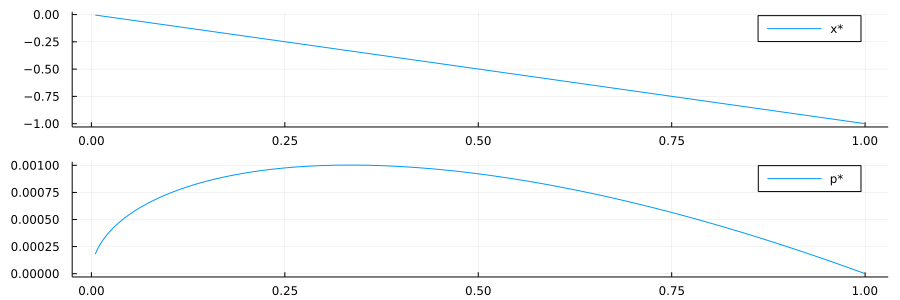

In [123]:
# A es una constante
A = (αn[1]+ωn[1]*ωn[1]/αn[1])/(2*Cn[1]*pr.ζ)
B = 0.5*ωn[1]/αn[1]
γlist = 0.005:0.001:1.0
rts = roots.([Polynomial([A*g,-1.0,-A,1.0]) for g in γlist])
z = getindex.(rts,2)
p0 = γlist - z.*z
q0 = 0.5*p0*ωn[1]/αn[1]
x0 = p0 - γlist;
plt0 = plot(γlist,x0,label="x*")
plt1 = plot(γlist,p0,label="p*")
plot(plt0,plt1,layout=(2,1),size=(900,300))

## Estabilidad del punto Fijo 

El Jacobiano puede escribirse derivando cada ecuacion y asumiendo que en un entorno del punto fijo $x>-1$ y que por lo tanto la derivada de $F_c$ tambien es cero. Considerando $u$ como funcion de $x$ y $p$ podemos escribir primero:

$
\begin{pmatrix}
0 & 1 & 0 & 0\\
-\omega_r^2 & -\omega_r & \omega_r^2 & 0\\
2C_1 \frac{\partial u}{\partial x} & 0 & -\alpha_1+2C_1\frac{\partial{u}}{\partial{p}} & -2\omega_1 \\
0 & 0 & \omega_1/2 & -\alpha_1
\end{pmatrix}
$

Viniendo de sistemas 2D puede intimidar una matriz de 4x4 pero recordar que para el estudio de las bifurcaciones todo lo que tenemos que hacer es calcular los autovalores, que se puede hacer numericamente, y evaluar cuando alguno de ellos cruza el eje imaginario (o sea la parte real se hace cero) o bien cuando un par conjugado cruza el eje imaginario (bifurcacion de Hopf).

Vamos a evaluar en el punto fijo donde $x=p-\gamma$, escribiendo las derivadas en funcion de $p$ y luego en funcion de la raiz del polinomico cubico con la misma sustitucion de antes $z=\sqrt{\gamma-p}$.

La primera derivada puede escribirse:

$\frac{\partial u}{\partial x} = \zeta\sqrt{\gamma-p} = \zeta z$

La segunda

$\frac{\partial{u}}{\partial{p}} = -\zeta \frac{p-\gamma+1}{2\sqrt{\gamma-p}} = - \zeta \frac{1-z^2}{2z} $

Con lo que el Jacobiano en funcion de la nueva variable queda escrito como:

$
\begin{pmatrix}
0 & 1 & 0 & 0 \\
-\omega_r^2 & -\omega_r & \omega_r^2 & 0 \\
2C_1 \zeta z & 0 & -\alpha_1-C_1\zeta \frac{1-z^2}{z} & -2\omega_1 \\
0 & 0 & \omega_1/2 & -\alpha_1
\end{pmatrix}
$

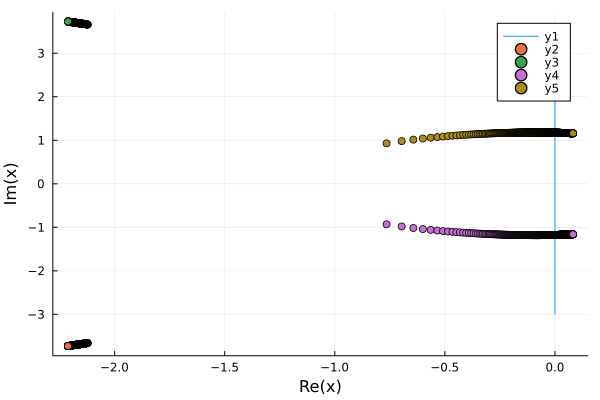

In [124]:
J = [
		[0 1.0 0 0;
		-ω0*ω0 -ω0 ω0*ω0 0;
		2*Cn[1]*pr.ζ*zi 0 -αn[1]-Cn[1]*pr.ζ*(1-zi*zi)/zi -2*ωn[1];
		0 0 ωn[1]/2 -αn[1]] for zi in z]
λ = [eigen(Ji).values for Ji in J];
V = [eigen(Ji).vectors for Ji in J];
plt1 = plot([0,0],[-3,3])
for n=1:4
    scatter!(plt1,getindex.(λ,n))
end    
plt1

En el grafico anterior se muestra como se "mueven" los autovalores en el plano complejo. Se ve como existen en pares de complejos conjugados (esto es consecuencia en definitiva de que se trata de osciladores acoplados). El primer par que esta mas asociado a la oscilacion de la lengüeta dada por las dos primeras variables (su autovector tiene componentes en las direcciones de $p$ y $q$ muy pequeñas) tiene siempre parte real negativa. En cambio el par asociado al modo del tubo (la parte imaginaria del autovalor tiende a la frecuencia del primer modo $\omega_1$), en algun momento cruza el eje imaginario y ahi se produce la bifurcacion de Hopf. Para ver el valor de $\gamma$ para el cual se produce la bifurcacion graficamos la parte real de $\lambda_3$ (o $\lambda_4$) en funcion del parametro de contro y buscamos el primer valor que es mayor que cero en parte real.

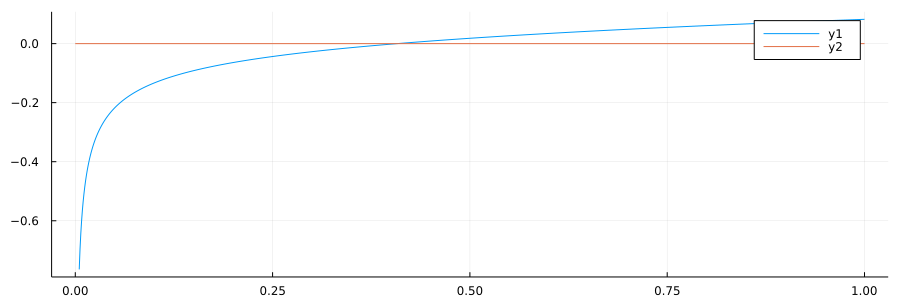

In [62]:
#plot(γ,real(λ3),size=(900,300))
plot(γlist,real(getindex.(λ,3)),size=(900,300))
plot!([0,1],[0,0])

In [63]:
nH=findfirst(real(getindex.(λ,3)).>0)
γH=γlist[nH]

0.409

Es decir que segun el calculo teorico la bifurcacion de Hopf deberia producirse entre $\gamma=0.408$ y $\gamma=0.409$. Para verificarlo colocamos la condicion inicial en el punto fijo con una pequeña perturbacion en la variable $q$ y evolucionamos para valores cercanos del parametro

In [64]:
n = nH
tspan = (0.0,15000)
sol1 = solve(ODEProblem(saxR!, [x0[n], 0, p0[n], q0[n]+0.0001], tspan, set(pr,γ,γlist[n])));
plt1 = plot(sol1,vars=(0,1),label=γlist[n])
sol2 = solve(ODEProblem(saxR!, [x0[n-1], 0, p0[n-1], q0[n-1]+0.0001], tspan, set(pr,γ,γlist[n-1])));
plt2 = plot(sol2,vars=(0,1),label=γlist[n-1])
sol3 = solve(ODEProblem(saxR!, [x0[n-2], 0, p0[n-2], q0[n-2]+0.0001], tspan, set(pr,γ,γlist[n-2])));
plt3 = plot(sol3,vars=(0,1),label=γlist[n-2])
plot(plt1,plt2,plt3,layout=(3,1),size=(900,300))

Como puede verse en realidad la bifurcacion parece ocurrir entre $\gamma=0.407$ y $\gamma=0.408$, esto podria deberse a un error numerico en el calculo de los autovalores para el valor de $\gamma=0.408$. Veamos los valores de la parte real de $\lambda_3$ entre $0.407$ y $0.409$

In [65]:
real(getindex.(λ[nH-2:nH],3))

3-element Vector{Float64}:
 -0.0002487715105994326
 -3.131455995482313e-5
  0.00018561699628638628

para $\gamma=0.408$, si bien el autovalor obtenido a partir de la matriz nos da negativo esta lo bastante cerca de cero como para suponer un error numerico. 

Veamos que nos dice BifurcationKit que tiene metodos de convergencia mucho mas precisos. Recordar que teniamos que definir nuestro campo vector "out of place" y dependiendo solo de las variables y los parametros y partimos de un valor de $\gamma$ cercano a $0.2$ y lo alimentamos con el valor que calculamos del punto fijo

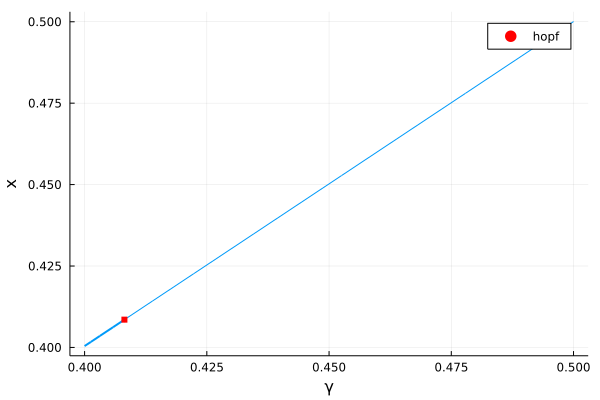

In [66]:
n = 200
saxr(u,p) = saxR!(similar(u),u,p,0)
opts = ContinuationPar(pMin=γlist[n],pMax=0.5, ds = 0.001, dsmax = 0.02,detectBifurcation=3,nInversion=8)
br1, = continuation(saxr,[x0[n], 0, p0[n], q0[n]],pr,(@lens _.γ), opts)
plot(br1)

In [67]:
br1.specialpoint[1]

BifurcationKit.SpecialPoint{Float64, NamedTuple{(:x,), Tuple{Float64}}, Vector{Float64}}
  type: Symbol hopf
  idx: Int64 5
  param: Float64 0.4081443040395366
  norm: Float64 0.40853139645966224
  printsol: NamedTuple{(:x,), Tuple{Float64}}
  x: Array{Float64}((4,)) [-0.4071592876473525, 0.0, 0.0009850163921842191, 0.03344018717784494]
  τ: BorderedArray{Vector{Float64}, Float64}
  ind_ev: Int64 2
  step: Int64 4
  status: Symbol guessL
  δ: Tuple{Int64, Int64}
  precision: Float64 1.7576143340747308e-7
  interval: Tuple{Float64, Float64}


br1 es la rama (branch) y tiene un unico punto especial. Cuando volcamos su contenido entre mucha otra informacion nos dice que ocurre para $\gamma=0.4081448$ con una precision apenas por debajo de $10^{-6}$, asi que ciertamente estaba mas cerca de $\gamma=0.408$ que de los vecinos en la grilla que calculamos antes.

# N modos version compleja

Ahora tenemos dos ecuaciones para la lengueta  y N ecuaciones complejas para los modos

$\dot{x} = v$

$\dot{v} = -\omega_r v + \omega_r^2 (p-\gamma-x+F_c)$

$\dot{p_n} = s_n p_n + C_n u$

con las funciones (por ahora) sin regularizar:

$p=2 \sum\limits_{n=1}^{N} Re(p_n)$

$F_c = K_c min(x+1,0)^2 (1 − \beta v)$    

$u = \zeta max(x+1,0)sign(\gamma-p)\sqrt{|\gamma-p|}$


In [68]:
function saxN!(dx,x,p,t)
    @unpack γ,ζ,β,ω0,Kc,s,C = p
    P = 2.0*sum(real.(x[3:end]))
    Fc = Kc*min(real(x[1])+1,0)^2*(1-β*x[2])
    u = ζ*max(real(x[1])+1,0)*sign(γ-P)*sqrt(abs(γ-P))
    dx[1] = x[2]
    dx[2] = -ω0*x[2]+ω0^2*(P-γ-x[1]+Fc)
    for n=3:length(x)
        dx[n] = s[n-2]*x[n]+C[n-2]*u
    end    
end

saxN! (generic function with 1 method)

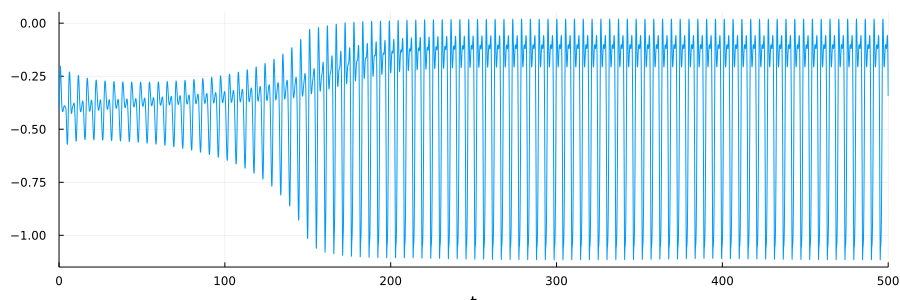

In [69]:
# solo definimos los parametros que cambian en el problema: la presion de soplado γ y la cantidad de modos
# la condicion inicial es con x en -γ y todos los modos en 0
γ0 = 0.405
nmodes = 8
xini = vcat([-γ0, 0],repeat([0.0+0.001im],nmodes))
tspan = (0.0,500)
prob = ODEProblem(saxN!, xini, tspan, set(pc,γ,γ0))
sol = solve(prob,saveat=dt);
plot(sol,vars=((t,x) -> (t,real(x)),0,1),size=(900,300),legend=false)

# N modos version real

Ahora vamos a tener dos ecuaciones para la lengueta  y 2N ecuaciones reales para los modos

$\dot{x} = v$

$\dot{v} = -\omega_r v + \omega_r^2 \left(\sum p_n -\gamma-x+F_c(x,v) \right)$

$\dot{p_n} = -\alpha_n p_n -2\omega_n q_n + 2C_n u\left(x, \sum p_n \right)$

$\dot{q_n} = -\alpha_n q_n + \omega_n p_n/2$

donde pusimos la dependencia la suma sobre las presiones de cada modo forma explicita y las funciones (sin regularizar):

$F_c(x,v) = K_c min(x+1,0)^2 (1 − \beta v)$    

$u\left(x, \sum p_n \right) = \zeta max(x+1,0)sign\left( \gamma-\sum p_n \right)\sqrt{\left|\gamma-\sum p_n\right|}$


In [70]:
function saxRN!(dx,x,p,t)
    @unpack γ,ζ,β,ω0,Kc,α,ω,C = p
    P = sum(x[3:2:end])
    Fc = Kc*min(real(x[1])+1,0)^2*(1-β*x[2])
    u = ζ*max(real(x[1])+1,0)*sign(γ-P)*sqrt(abs(γ-P))
    dx[1] = x[2]
    dx[2] = -ω0*x[2]+ω0^2*(P-γ-x[1]+Fc)
    for n=3:2:length(x)
        m = (n-1)÷2
        dx[n] = -α[m]*x[n]-2*ω[m]*x[n+1]+2*C[m]*u
        dx[n+1] = -α[m]*x[n+1]+0.5*ω[m]*x[n]
    end
    dx
end

saxRN! (generic function with 1 method)

In [71]:
γ0 = 0.405
nmodes = 8
xini = vcat([-γ0, 0],repeat([0.0,0.001],nmodes))
tspan = (0.0,500)
prob = ODEProblem(saxRN!, xini, tspan, set(pr,γ,γ0))
sol2 = solve(prob,saveat=dt);

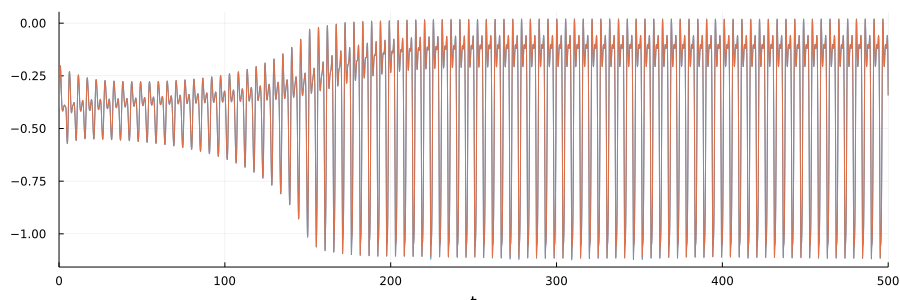

In [72]:
plot(sol2,vars=(0,1),size=(900,300),legend=false)
plot!(sol,vars=((t,x) -> (t,real(x)),0,1))

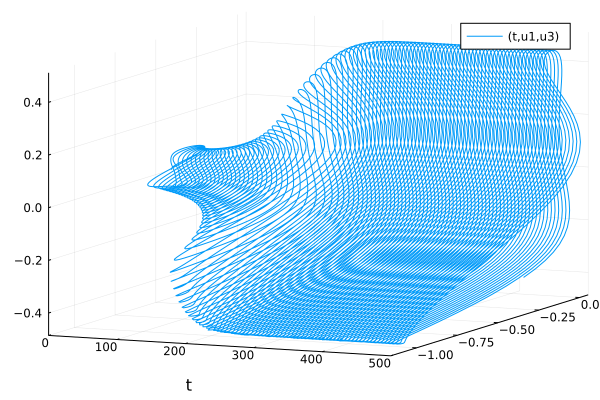

In [73]:
plot(sol2,vars=(0,1,3))

## Puntos fijos. 

Ahora el calculo analitico se hace imposible pero vamos a echar mano de metodos numericos para encontra ceros (o raices) de funciones muy eficientes basados en aritmetica de intervalos. Para esto primero vamos a llevar las $2N+2$ ecuaciones a $N$ ecuaciones con las $p_n$ como incognitas. Sigue siendo valido que para valores de $\gamma$ no demasiado proximos a cero (recordar que asumiamos $\gamma>p_*$ ni ce3rcanos a $1$ (para cumplir con $x>-1$):

$v_*=0$

$x_*=\sum{p_{n*}}-\gamma$

$q_{n*}=\frac{\omega_n p_{n*}}{2\alpha_n}$

La $N$ ecuaciones a resolver van a tener la forma:

$A_n p_n -  (\sum{p_n} - \gamma+1) \sqrt{\gamma - \sum{p_n}}=0$

donde como antes definimos el parametro, que ahora depende de $n$:

$A_n = \frac{1}{2C_n\zeta}\left(\alpha_n+\frac{\omega_n^2}{\alpha_n}\right)$

Para resolver este sistema usamos la funcion roots del paquete IntervalRootFinding que necesita que la funcion reciba como argumentos solo los intervalos o productos de intervalos y devuelve un StaticArray, por lo tanto tenemos que definir una funcion que arme ese input y procese ese output.

In [18]:
function fixedpoints(γ,ζ,α,ω,C,pinterval)
    An = @. (α+ω*ω/α)/(2.0*C*ζ)
    function fsv(pn)
        p = sum(pn)
        dp = @. An*pn-(p-γ+1)*sqrt(γ-p)
        return SVector{length(dp),typeof(dp[1])}(dp)
    end  
    X = pinterval[1]..pinterval[2]
    rts = roots(fsv, X × X × X × X × X × X × X × X)
    p0=mid(rts[1].interval)
end    

fixedpoints (generic function with 1 method)

In [20]:
γlist = 0.2:0.001:1.0
ζ = 0.6
p0 = fixedpoints.(γlist,ζ,(αn,),(ωn,),(Cn,),([-0.01,0.01],))
q0 = [0.5*pi.*ωn./αn for pi in p0]
P0 = [sum(pi) for pi in p0]
x0 = P0 - γlist;

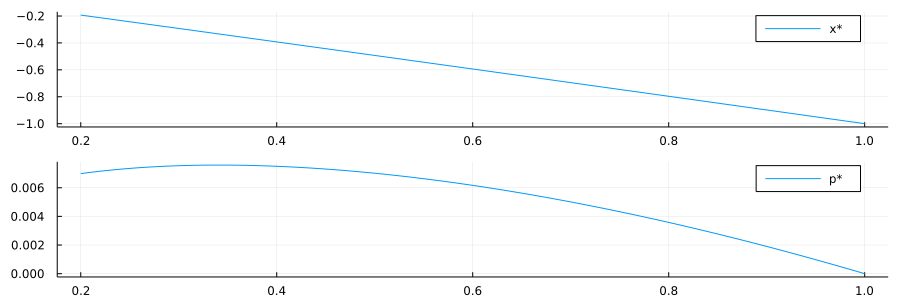

In [128]:
plt0 = plot(γlist,x0,label="x*")
plt1 = plot(γlist,P0,label="p*")
plot(plt0,plt1,layout=(2,1),size=(900,300))

POdemos ver que de forma similar al caso de un solo modo, la presion de cada modo en el punto fijo esta en torno a $0.001$ (y la suma llega a un maximo de $P0=0.008$), y la coordenada $x_*$ es muy cercana a $-\gamma$. 

Para verificar que efectivamente es el punto fijo calculamos la derivada en ese punto para todos los valores de $\gamma$. Para eso definimos el campo vector como una funcion "out of place" que depende de las variables y los parametros unicamente y que luego nos va a servir para BifurcationKit

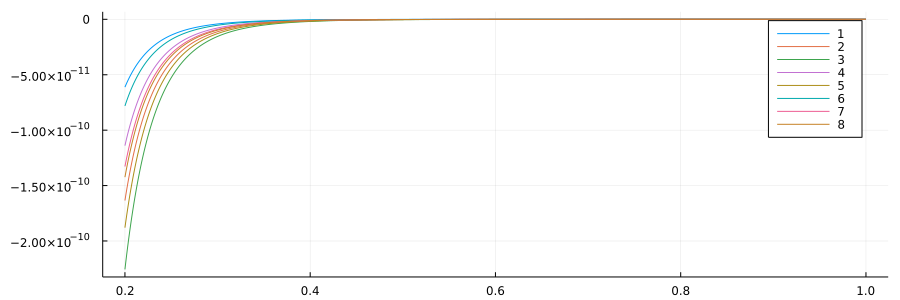

In [129]:
nmodes = 8
saxrn(u,p) = saxRN!(similar(u),u,p,0)
pf = [vcat([x0[n],0],vec([p0[n] q0[n]]')) for n=1:length(x0)]
pv = [set(pr,γ,γi) for γi in γlist]
dpf = saxrn.(pf,pv)
plt1 = plot(size=(900,300))
for n=1:8
    plot!(plt1,γlist,getindex.(dpf,2*n+1),label=n)
end
plt1

La derivada esta dentro del error numerico (que crece para $\gamma$ bajos), por lo que se verifica que calculamos bien el punto fijo en funcion del parametro.

## Estabilidad

El ultimo esfuerzo es calcular el Jacobiano para el sistema de N modos. Si una matriz de 4x4 ya podia inhibir un poco en este caso vamos a tener una matriz de 18x18 para 8 modos. Sin embargo si encontramos una forma sistematica de construirla en funcion de los parametros para ser evaluada en el punto fijo, luego podemos calcular numericamente los autovalores. 

La primera fila es trivial porque $\dot{x}$ solo depende de$v$. Para la segunda tenemos que tener en cuenta que ahora en lugar de $p$ tenemos $\sum{p_n}$ y que vamos a tener como derivada a $\omega_r^2$ para todas las variables $p_n$. En la matriz colocamos puntos suspensivos para indicar que lo mismo sucede hasta $p_8$. Con respecto a las ecuaciones para $\dot{p_n}$ y $\dot{q_n}$ tambien hay una sistematica. 

Para simplificar la notacion vamos a redefinir $z$ como: 

$z=\sqrt{\gamma-\sum{p_n}}$

Cuando derivemos la ecuacion correspondiente al modo n con respecto a las variables que corresponen al mismo modo vamos a tener como antes bloques sobre la diagonal

$
\begin{pmatrix}
-\alpha_n-C_n\zeta\frac{1-z^2}{z} & -2\omega_n \\
\omega_n/2 & -\alpha_n 
\end{pmatrix}
$

En cambio fuera de la diagonal cuando derivamos las ecuaciones del modo n con respecto a las variables $p$ y $q$ de otro modo no va a figurar ninguno de los terminos con $\omega_n$ ni $\alpha_n$ y solo queda la parte que depende de la suma de las presiones y tendremos bloques de 2x2 asi

$
\begin{pmatrix}
-C_n\zeta\frac{1-z^2}{z} & 0 \\
0 & 0  
\end{pmatrix}
$

El ultimo detalle es que la primera columna tambien presenta un elemento

$2C_n\zeta z$ 

para cada una de las filas que corresponden a las derivadas respecto a $p_n$.

Con todo eso la matriz queda armada como:

$
\begin{pmatrix}
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & ...\\
-\omega_r^2 & -\omega_r & \omega_r^2 & 0 & \omega_r^2 & 0 & \omega_r^2 & 0 & \dots\\
2C_1\zeta z & 0 & -\alpha_1-C_1\zeta\frac{1-z^2}{z} & -2\omega_1 & -C_1\zeta\frac{1-z^2}{z} & 0& -C_1\zeta\frac{1-z^2}{z} & 0 & \dots\\
0 & 0 & \omega_1/2 & -\alpha_1 & 0 & 0 & 0 & 0 & \dots\\
2C_2\zeta z & 0 & -C_2\zeta\frac{1-z^2}{z} & 0 & -\alpha_2-C_2\zeta\frac{1-z^2}{z} & -2\omega_2 & -C_2\zeta\frac{1-z^2}{z} & 0 & \dots\\
0 & 0 & 0 & 0 & \omega_2/2 & -\alpha_2 & 0 & 0 & \dots\\
2C_3\zeta z & 0 & -C_3\zeta\frac{1-z^2}{z} & 0 & -C_3\zeta\frac{1-z^2}{z} & 0 & -\alpha_3-C_3\zeta\frac{1-z^2}{z} & -2\omega_3 & \dots\\    
0 & 0 & 0 & 0 & 0 & 0 & \omega_3/2 & -\alpha_3 & \dots  \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots
\end{pmatrix}
$


In [78]:
function JsaxRn0(u,p)
    @unpack γ,ζ,β,ω0,Kc,α,ω,C = p
    P0 = sum(u[3:2:end])
    z = sqrt(γ-P0)
    nmodes = length(α)
    J0 = zeros(Float64,(2*(nmodes+1),2*(nmodes+1)))
    J0[1,2] = 1.0
    J0[2,1] = -ω0*ω0
    J0[2,2] = -ω0
    J0[2,3:2:2*nmodes+1] .= ω0*ω0
    for n=1:nmodes
        J0[2*n+1,1] = 2*C[n]*ζ*z
        J0[2*n+1,3:2:2*nmodes+1] .= -C[n]*ζ*(1-z*z)/z
        J0[2*n+1,2*n+1] += -α[n]
        J0[2*n+2,2*n+2] = -α[n]
        J0[2*n+1,2*n+2] = -2*ω[n]
        J0[2*n+2,2*n+1] = ω[n]/2.0
    end
    J0
end    

JsaxRn0 (generic function with 1 method)

In [79]:
J0 = JsaxRn0.(pf,pv)
λ = [eigen(Ji,sortby = x -> abs(imag(x))).values for Ji in J0];

Como aparentemente eigen ordena los autovalores en orden "lexicografico" y nosotros queremos agrupados los pares complejos conjugados de menor a mayor frecuencia los ordenamos por el modulo de la parte imaginaria. Al graficar (solo un autovalor del par) vemos que la frecuencia se mantiene mas o menos constante en el rango y que corresponde aproximadamente a la frecuencia de cada uno de los ocho modos. Por otro lado se ve que los tres primeros modos cruzan el cero.

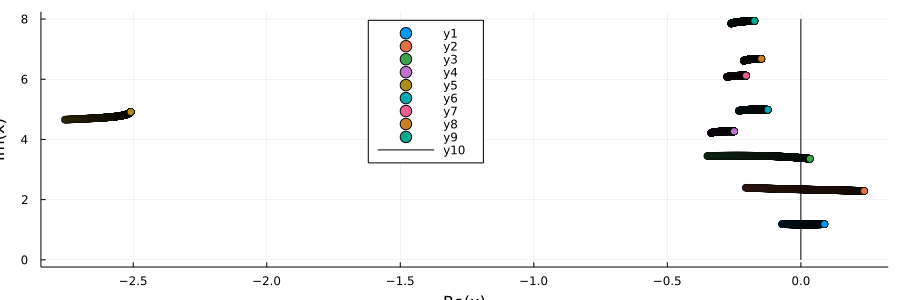

In [80]:
plt1 = plot(size=(900,300))
for n=1:9
    scatter!(plt1,getindex.(λ,2*n-1))
end  
plot!(plt1,[0,0],[0,8],color=:black,legend=:top)

Ahora graficamos la parte real de los tres primeros modos para ver a que valor del parametro se produce el cruce con cero

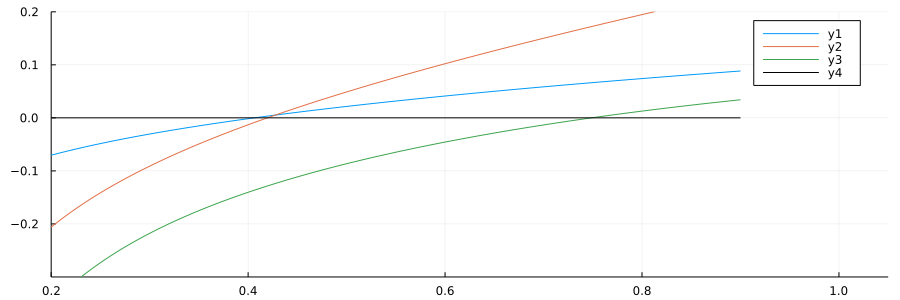

In [81]:
plt1 = plot()
for n=1:2:5
    plot!(plt1,γlist,getindex.(real.(λ),n))
end    
plot!([0.2,0.9],[0,0],color=:black,size=(900,300),xlims=(0.2,1.05),ylims=(-0.3,0.2))

Los dos primeros modos cortan el eje muy cerca de $\gamma=0.4$. Vamos a concentrarnos en esas dos posibles bifurcaciones de Hopf.

In [82]:
nH1=findfirst(real(getindex.(λ,1)).>0)
γH1=γlist[nH1]

0.407

In [83]:
nH2=findfirst(real(getindex.(λ,3)).>0)
γH2=γlist[nH2] 

0.42

In [84]:
nH3=findfirst(real(getindex.(λ,5)).>0)
γH3=γlist[nH3] 

0.749

Es decir que la primera Hopf correspondiente al modo 1 ocurre entre 0.406 y 0.407 mientras que la segunda entre 0.419 y 0.2. y la tercera entre 0.748 y 0.749

# Diagrama de Bifurcaciones usando Bifurcation Kit

Vamos a intentar detectar las tres bifurcaciones de Hopf usando BifurcationKit. Partimos de $\gamma=0.3$ que corresponde al indice 101 (lo necesitamos para pasar el punto fijo). No es imprescindible pero ayuda a una buena convergencia. Vemos que detecta dos bifurcaciones y cuando invocamos estos puntos especiales vemos que estan en 0.4063 y 0.4195 respectivamente, por lo que en este caso el metodo de la diagonalizacion del jacobiano funciono bien al menos con una resolucion de 0.001 en el parametro.

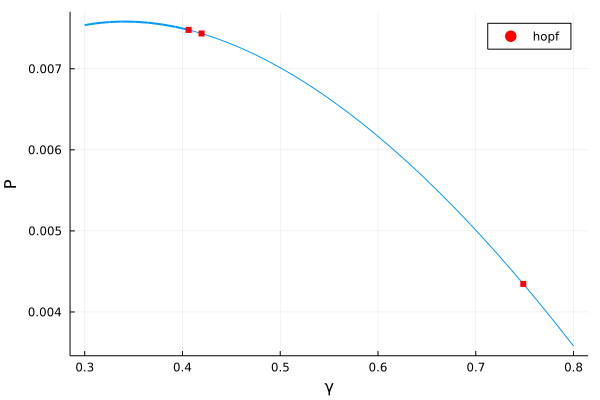

In [85]:
n = 101
γini = γlist[n]
saxrn(u,p) = saxRN!(similar(u),u,p,0)
opts = ContinuationPar(pMin=γini,pMax=0.8, ds = 0.001, dsmax = 0.01,detectBifurcation=3,nInversion=8)
br1, = continuation(saxrn,JsaxRn0,pf[n],set(pr,γ,γini),(@lens _.γ), opts;
    recordFromSolution = (x,p) -> (x = x[1], P = sum(x[3:2:end])))
plot(br1,vars=(:param,:P),xlabel="γ")

In [86]:
jet  = BifurcationKit.getJet(saxrn,JsaxRn0)
hopf1 = computeNormalForm(jet..., br1, 1)

SubCritical - Hopf bifurcation point at γ ≈ 0.4063046348179685.
Frequency ω ≈ 1.1745603513283376
Period of the periodic orbit ≈ 5.349393328383497
Normal form z⋅(iω + a⋅δp + b⋅|z|²): 
(a = 0.34224544755935093 + 0.003702240909159535im, b = 1.1017219841709733 + 1.640695743748634im)


In [87]:
hopf2 = computeNormalForm(jet..., br1, 2)

SuperCritical - Hopf bifurcation point at γ ≈ 0.41954006054172854.
Frequency ω ≈ 2.33979677268369
Period of the periodic orbit ≈ 2.685355147307484
Normal form z⋅(iω + a⋅δp + b⋅|z|²): 
(a = 0.9013181365930766 + 0.1293853444373682im, b = -0.06809215686328349 + 0.007506355647639698im)


In [88]:
hopf3 = computeNormalForm(jet..., br1, 3)

SuperCritical - Hopf bifurcation point at γ ≈ 0.7486261188788815.
Frequency ω ≈ 3.38726060983451
Period of the periodic orbit ≈ 1.8549459374153563
Normal form z⋅(iω + a⋅δp + b⋅|z|²): 
(a = 0.4267882949528944 + 0.20639563008271117im, b = -0.0006121558108893595 - 0.0005072946028446387im)


In [89]:
jet  = BifurcationKit.getJet(saxrn,JsaxRn0)
# newton parameters
optn_po = NewtonPar(verbose = false, tol = 1e-8,  maxIter = 10)
norminf(x) = norm(x, Inf);

## Modo 1

In [118]:
# barrido rapido 
args_po = ( recordFromSolution = (x, p) -> (xtt = BK.getPeriodicOrbit(p.prob, x,  @set pr.γ = p.p);
        return (amp=diff(extrema(xtt[3,:])),period = getPeriod(p.prob, x, @set pr.γ = p.p))), normC = norminf)
opts_po_cont = ContinuationPar(dsmax = 0.01, ds= -0.001, dsmin = 1e-5, pMax = 1.0, pMin=0.3,
    maxSteps = 110, newtonOptions = (@set optn_po.tol = 1e-7),
    nev = 3, precisionStability = 1e-8, detectBifurcation = 0, plotEveryStep = 30, saveSolEveryStep=1);
Mt = 40 # number of time sections
br_pocoll, ucoll, = @time continuation(jet...,br1, 1, opts_po_cont,PeriodicOrbitOCollProblem(Mt, 5, 3);
    verbosity = 0,plot = false,args_po...)

LoadError: MethodError: no method matching diff(::Tuple{Float64, Float64})
[0mClosest candidates are:
[0m  diff([91m::AbstractRange{T}[39m; dims) where T at C:\Users\Camilo\AppData\Local\Programs\Julia-1.7.3\share\julia\base\multidimensional.jl:971
[0m  diff([91m::SparseArrays.AbstractSparseMatrixCSC[39m; dims) at C:\Users\Camilo\AppData\Local\Programs\Julia-1.7.3\share\julia\stdlib\v1.7\SparseArrays\src\linalg.jl:1110
[0m  diff([91m::StaticVector[39m) at C:\Users\Camilo\.julia\packages\StaticArrays\12k3X\src\mapreduce.jl:285
[0m  ...

Solo detecta la Fold que da origen a los CL estable e inestable que es donde la rama del modo "pega la vuelta" pero no otros cambios de estabilidad del CL. Como la Hopf es subcritica el CL va "hacia atras" en el parametro y luego cambia su estabilidad en la fold

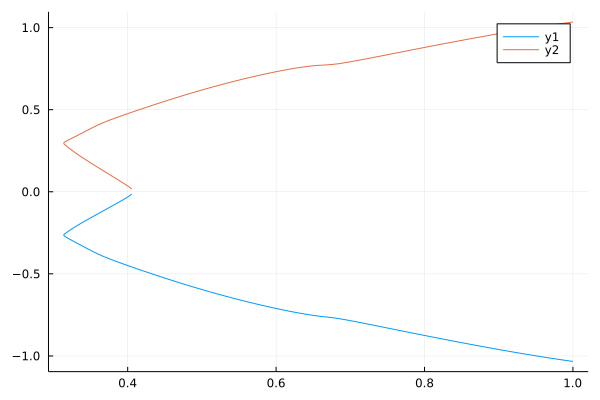

In [117]:
plot(br_pocoll.param,getindex.(br_pocoll.amp,1))
plot!(br_pocoll.param,getindex.(br_pocoll.amp,2))

In [117]:
# ATENCION NO CORRER ESTA CELDA los resultados se guardan al final
# metodo in extenso demora mucho tiempo
opts_po_cont = ContinuationPar(dsmax = 0.01, ds= -0.001, dsmin = 1e-5, pMax = 1.0, pMin=0.25,
    maxSteps = 110, newtonOptions = (@set optn_po.tol = 1e-7),
    nev = 3, precisionStability = 1e-8, detectBifurcation = 3, plotEveryStep = 30, saveSolEveryStep=1);
Mt = 40 # number of time sections
br_pocoll1, ucoll, = @time continuation(jet...,br1, 1, opts_po_cont,PeriodicOrbitOCollProblem(Mt, 5, 3);
    verbosity = 1,plot = false,args_po...)

#####################################################
────────── Pseudo-Arclength Continuation ────────────

─────────────────  INITIAL GUESS ────────────────────
--> convergence of initial guess = OK

--> parameter = 0.4053046348179685, initial step

───────────────── INITIAL TANGENT ───────────────────
--> convergence of initial guess = OK

--> parameter = 0.40529796815130187, initial step (bis)
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 0 
Step size = -1.0000e-03
Parameter γ = 4.0530e-01 ⟶  4.0482e-01 [guess]
Parameter γ = 4.0530e-01 ⟶  4.0478e-01 
Predictor: SecantPred()
--> bp Bifurcation point at p ≈ 0.4053299852689686, δn_unstable = 1,  δn_imag = 0
──────────────────────────────────────────────────────────────────────
Continuation Step 1 
Step size = -1.4050e-03
Parameter γ = 4.0533e-01 ⟶  4.0463e-01 [guess]
Parameter γ = 4.0533e-01 ⟶  4.0458e-01 
Predictor: SecantPred()
───────────────────────────────────────

11-element Vector{Float64}:
 0.026772150605742423
 0.014852806655103967
 0.008388017103647116
 0.03157937161776833
 0.010247801639652443
 0.010400392000113279
 0.00993763397757641
 0.010848655347849345
 0.00920221268192073
 0.013438014943906729
 0.00796359777493788

Newton correction failed
--> Newton Residuals history = 
Halving continuation step, ds=-0.005
──────────────────────────────────────────────────────────────────────
Continuation Step 18 
Step size = -5.0000e-03
Parameter γ = 3.1741e-01 ⟶  3.1487e-01 [guess]
Parameter γ = 3.1741e-01 ⟶  3.1502e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 19 
Step size = -6.6000e-03
Parameter γ

11-element Vector{Float64}:
 0.06291040000735162
 0.15865724974558298
 0.07221604059968453
 1.0947244286140083
 1.3516809891388042
 0.47347502680290465
 1.0386102501307466
 0.023672091293887147
 0.05920569894976577
 0.14541850437499032
 0.07081406750349034

 = 3.1502e-01 ⟶  3.1186e-01 [guess]
Newton correction failed
--> Newton Residuals history = 
Halving continuation step, ds=-0.0033000000000000004
──────────────────────────────────────────────────────────────────────
Continuation Step 19 
Step size = -3.3000e-03
Parameter γ = 3.1502e-01 ⟶  3.1344e-01 [guess]
Parameter γ = 3.1502e-01 ⟶  3.1385e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 20 
Step size = -4.1085e-03
Parameter γ

11-element Vector{Float64}:
     0.0964664393271005
     0.029590006915705402
   121.44168776449324
 62711.4843749184
     8.823443571910924e8
     3.289197913469166e10
     2.796954585291667e9
     5.2000179803897345e8
     1.3117286986753149e10
     7.547397913690307e9
     5.790826944380605e14

 = 3.1385e-01 ⟶  3.1243e-01 [guess]
Newton correction failed
--> Newton Residuals history = 
Halving continuation step, ds=-0.00205425
──────────────────────────────────────────────────────────────────────
Continuation Step 20 
Step size = -2.0543e-03
Parameter γ = 3.1385e-01 ⟶  3.1314e-01 [guess]
Parameter γ = 3.1385e-01 ⟶  3.1446e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 21 
Step size = -2.5575e-03
Parameter γ = 3.1446e-01 ⟶  3.1478e-01 [guess]
Parameter γ = 3.1446e-01 ⟶  3.1499e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 22 
Step size = -3.1841e-03
Parameter γ = 3.1499e-01 ⟶  3.1563e-01 [guess]
Parameter γ = 3.1499e-01 ⟶  3.1571e-01 
Predictor: SecantPred()
--> bp Bifurcation point at p ≈ 0.3154618857794615, δn_unstable = 1,  δn_imag = 0
──────────────────────────────────────────────────────────────────────
Continuation Step 23 
Step s

Parameter γ = 5.1078e-01 ⟶  5.2231e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 51 
Step size = -1.0000e-02
Parameter γ = 5.2231e-01 ⟶  5.3382e-01 [guess]
Parameter γ = 5.2231e-01 ⟶  5.3396e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 52 
Step size = -1.0000e-02
Parameter γ = 5.3396e-01 ⟶  5.4559e-01 [guess]
Parameter γ = 5.3396e-01 ⟶  5.4568e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 53 
Step size = -1.0000e-02
Parameter γ = 5.4568e-01 ⟶  5.5738e-01 [guess]
Parameter γ = 5.4568e-01 ⟶  5.5744e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 54 
Step size = -1.0000e-02
Parameter γ = 5.5744e-01 ⟶  5.6917e-01 [guess]
Parameter γ = 5.5744e-01 ⟶  5.6920e-01 
Predictor: SecantPred()
────────────────────────

Parameter γ = 8.0141e-01 ⟶  8.1398e-01 [guess]
Parameter γ = 8.0141e-01 ⟶  8.1404e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 83 
Step size = -1.0000e-02
Parameter γ = 8.1404e-01 ⟶  8.2665e-01 [guess]
Parameter γ = 8.1404e-01 ⟶  8.2670e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 84 
Step size = -1.0000e-02
Parameter γ = 8.2670e-01 ⟶  8.3936e-01 [guess]
Parameter γ = 8.2670e-01 ⟶  8.3941e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 85 
Step size = -1.0000e-02
Parameter γ = 8.3941e-01 ⟶  8.5211e-01 [guess]
Parameter γ = 8.3941e-01 ⟶  8.5213e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 86 
Step size = -1.0000e-02
Parameter γ = 8.5213e-01 ⟶  8.6486e-01 [guess]
Parameter γ = 8.5213e-01 ⟶  8.6490e-01 
P

( ┌─ Branch number of points: 99
 ├─ Branch of PeriodicOrbit from Hopf bifurcation point.
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter γ starts at 0.4053046348179685, ends at 1.0
 └─ Special points:

If `br` is the name of the branch,
ind_ev = index of the bifurcating eigenvalue e.g. `br.eig[idx].eigenvals[ind_ev]`

- #  1,    bp at γ ≈ +0.40532999 ∈ (+0.40532999, +0.40533001), |δp|=2e-08, [   guessL], δ = (-1,  0), step =   1, eigenelements in eig[  2], ind_ev =   2
- #  2,    bp at γ ≈ +0.31546189 ∈ (+0.31522497, +0.31546189), |δp|=2e-04, [converged], δ = (-1,  0), step =  23, eigenelements in eig[ 24], ind_ev =   1
- #  3,    bp at γ ≈ +0.32764752 ∈ (+0.32764545, +0.32764752), |δp|=2e-06, [converged], δ = ( 1,  0), step =  28, eigenelements in eig[ 29], ind_ev =   1
- #  4,    bp at γ ≈ +0.34793041 ∈ (+0.34775523, +0.34793041), |δp|=2e-04, [converged], δ = (-1,  0), step =  33, eigenelements in eig[ 34], ind_ev =   1
- #  5,    bp at γ ≈ +0.65536492 ∈ (+0.65535837, +0.65536492

In [126]:
# como tarda mucho en calcularlo lo guardamos en formato jld2
using JLD2
@save "modo1b.jld2" br_pocoll1

## Modo 2

In [91]:
# barrido rapido
opts_po_cont = ContinuationPar(dsmax = 0.01, ds= 0.001, dsmin = 1e-5, pMax = 1.0, pMin=0.4,
    maxSteps = 110, newtonOptions = (@set optn_po.tol = 1e-7),
    nev = 3, precisionStability = 1e-8, detectBifurcation = 0, plotEveryStep = 30, saveSolEveryStep=1);
Mt = 40 # number of time sections
br_pocoll2, ucoll, = @time continuation(jet...,br1, 2, opts_po_cont,PeriodicOrbitOCollProblem(Mt, 5, 3);
    verbosity = 0,plot = false,args_po...)

152.681014 seconds (53.17 M allocations: 330.372 GiB, 31.29% gc time)


( ┌─ Branch number of points: 79
 ├─ Branch of PeriodicOrbit from Hopf bifurcation point.
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter γ starts at 0.42054006054172854, ends at 1.0
, BorderedArray{Vector{Float64}, Float64}([-1.1412399364872439, 0.18996975837318764, 0.03807205273439308, 0.016819083492744507, -0.7700190543741161, 0.27922408296224865, -0.04342105613060261, 0.06025656065115096, -0.027619711898112288, 0.052234540941984424  …  0.052234540941984424, -0.14609739783969228, -0.04129356297556502, -0.026728629047836364, 0.0017251942907270056, -0.0576382770202781, 0.013228890835465107, -0.002859757629316631, -0.011671719965299263, 2.6205942719548254], 1.0), BorderedArray{Vector{Float64}, Float64}([-0.0740269667058726, 0.1581125015919465, 0.00918714115497763, -0.01037584703044253, -0.2798484708975251, 0.744238673821352, 0.07410098618827658, 0.04142266085284351, 0.09933816864768395, 0.027134123832255205  …  0.027134123832255205, -0.22641231348465818, 0.035411625908723515, -0.012

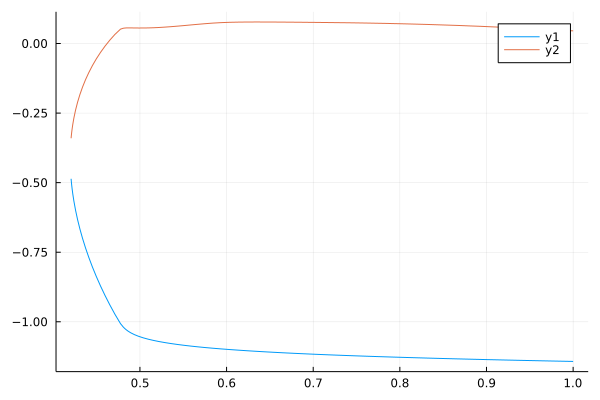

In [113]:
plot(br_pocoll2.param,br_pocoll2.min)
plot!(br_pocoll2.param,br_pocoll2.max)

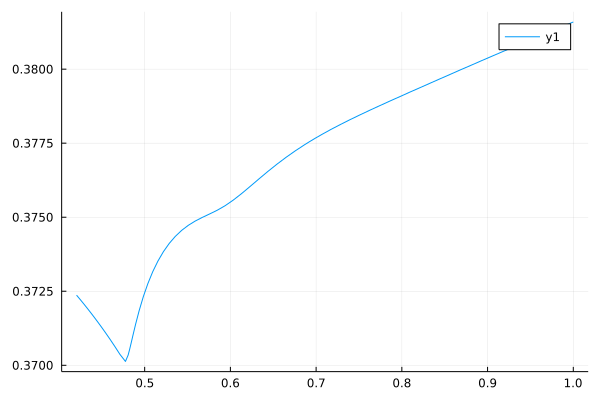

In [114]:
plot(br_pocoll2.param,1 ./br_pocoll2.period)

In [115]:
# ATENCION NO CORRER! los resultados se guardan al final
opts_po_cont = ContinuationPar(dsmax = 0.01, ds= 0.001, dsmin = 1e-4, pMax = 0.7, pMin=0.4,
    maxSteps = 110, newtonOptions = (@set optn_po.tol = 1e-7),
    nev = 3, precisionStability = 1e-8, detectBifurcation = 3, plotEveryStep = 30, saveSolEveryStep=1);
Mt = 30 # number of time sections
br_pocoll2, ucoll, = @time continuation(jet...,br1, 2, opts_po_cont,PeriodicOrbitOCollProblem(Mt, 5, 3);
    verbosity = 1,plot = false,args_po...)

#####################################################
────────── Pseudo-Arclength Continuation ────────────

─────────────────  INITIAL GUESS ────────────────────
--> convergence of initial guess = OK

--> parameter = 0.42054006054172854, initial step

───────────────── INITIAL TANGENT ───────────────────
--> convergence of initial guess = OK

--> parameter = 0.4205467272083952, initial step (bis)
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 0 
Step size = 1.0000e-03
Parameter γ = 4.2054e-01 ⟶  4.2065e-01 [guess]
Parameter γ = 4.2054e-01 ⟶  4.2063e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 1 
Step size = 1.4050e-03
Parameter γ = 4.2063e-01 ⟶  4.2076e-01 [guess]
Parameter γ = 4.2063e-01 ⟶  4.2076e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 2 
Step size = 1.9740e-03
Paramete

11-element Vector{Float64}:
    0.1321488871260459
    1.1377356524006699
    0.6191025833187431
    0.20762228295954102
    0.3114089545135077
    0.0953563520162109
    0.35698353810928807
    0.18487582239419592
  329.29061437527196
 3937.316168925043
 9930.574524717726

Newton correction failed
--> Newton Residuals history = 
Halving continuation step, ds=0.005
──────────────────────────────────────────────────────────────────────
Continuation Step 20 
Step size = 5.0000e-03
Parameter γ

11-element Vector{Float64}:
 0.041344649355900376
 0.012612003195421106
 0.004448314417581617
 0.004072652589046932
 0.00586067409619323
 0.0033862215308801402
 0.034300785810577994
 0.008723388452360065
 0.003649963301679382
 0.00993887665843829
 0.003885204216216409

 = 4.7765e-01 ⟶  4.8092e-01 [guess]
Newton correction failed
--> Newton Residuals history = 
Halving continuation step, ds=0.0025
──────────────────────────────────────────────────────────────────────
Continuation Step 20 
Step size = 2.5000e-03
Parameter γ = 4.7765e-01 ⟶  4.7929e-01 [guess]
Parameter γ = 4.7765e-01 ⟶  4.8079e-01 
Predictor: SecantPred()
--> pd Bifurcation point at p ≈ 0.48056166875490763, δn_unstable = 1,  δn_imag = 1
──────────────────────────────────────────────────────────────────────
Continuation Step 21 
Step size = 3.1125e-03
Parameter γ = 4.8056e-01 ⟶  4.8230e-01 [guess]
Parameter γ = 4.8056e-01 ⟶  4.8216e-01 
Predictor: SecantPred()
--> bp Bifurcation point at p ≈ 0.48165920733416806, δn_unstable = 1,  δn_imag = 0
──────────────────────────────────────────────────────────────────────
Continuation Step 22 
Step size = 4.1085e-03
Parameter γ = 4.8166e-01 ⟶  4.8375e-01 [guess]
Parameter γ = 4.8166e-01 ⟶  4.8361e-01 
Predictor: SecantPred()
--> bp Bifurcation poin

──────────────────────────────────────────────────────────────────────
Continuation Step 49 
Step size = 1.0000e-02
Parameter γ = 6.6164e-01 ⟶  6.7221e-01 [guess]
Parameter γ = 6.6164e-01 ⟶  6.7234e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 50 
Step size = 1.0000e-02
Parameter γ = 6.7234e-01 ⟶  6.8304e-01 [guess]
Parameter γ = 6.7234e-01 ⟶  6.8315e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 51 
Step size = 1.0000e-02
Parameter γ = 6.8315e-01 ⟶  6.9395e-01 [guess]
Parameter γ = 6.8315e-01 ⟶  6.9407e-01 
Predictor: SecantPred()
──────────────────────────────────────────────────────────────────────
Continuation Step 52 
Step size = 1.0000e-02
Parameter γ = 6.9407e-01 ⟶  7.0000e-01 [guess]
Parameter γ = 6.9407e-01 ⟶  7.0000e-01 
Predictor: SecantPred()
8284.796862 seconds (57.16 M allocations: 134.532 GiB, 0.17% gc time, 0.07% compilation time

( ┌─ Branch number of points: 54
 ├─ Branch of PeriodicOrbit from Hopf bifurcation point.
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter γ starts at 0.42054006054172854, ends at 0.7
 └─ Special points:

If `br` is the name of the branch,
ind_ev = index of the bifurcating eigenvalue e.g. `br.eig[idx].eigenvals[ind_ev]`

- #  1,    pd at γ ≈ +0.48056167 ∈ (+0.48034403, +0.48056167), |δp|=2e-04, [converged], δ = ( 1,  1), step =  21, eigenelements in eig[ 22], ind_ev =   2
- #  2,    bp at γ ≈ +0.48165921 ∈ (+0.48113565, +0.48165921), |δp|=5e-04, [converged], δ = ( 1,  0), step =  22, eigenelements in eig[ 23], ind_ev =   3
- #  3,    bp at γ ≈ +0.48298512 ∈ (+0.48234541, +0.48298512), |δp|=6e-04, [converged], δ = (-1,  0), step =  23, eigenelements in eig[ 24], ind_ev =   3
- #  4,    bp at γ ≈ +0.49629543 ∈ (+0.49507380, +0.49629543), |δp|=1e-03, [converged], δ = ( 1,  0), step =  27, eigenelements in eig[ 28], ind_ev =   3
- #  5,    bp at γ ≈ +0.49848985 ∈ (+0.49817201, +0.4984898

In [135]:
@save "modo2.jld2" br_pocoll2

In [116]:
[sp.type for sp in br_pocoll2.specialpoint]'

8-element Vector{Symbol}:
 :pd
 :bp
 :bp
 :bp
 :bp
 :bp
 :bp
 :ns

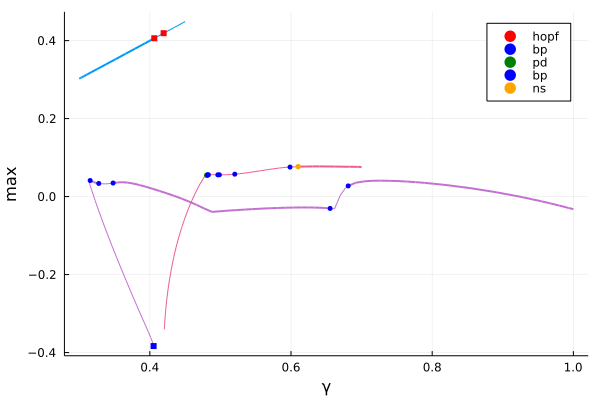

In [138]:
plot(br1)
plot!(br_pocoll1)
plot!(br_pocoll2)